# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# all my imports in the same place
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import random as rnd
import cv2

%matplotlib inline
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.contrib.layers import flatten
from PIL import Image

In [2]:
training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]

image_shape = X_train.shape[1:]

n_classes = len(set(train['labels']))

signnames = pd.read_csv('signnames.csv')['SignName']

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print ("Signal Names\n", signnames)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
Signal Names
 0                                  Speed limit (20km/h)
1                                  Speed limit (30km/h)
2                                  Speed limit (50km/h)
3                                  Speed limit (60km/h)
4                                  Speed limit (70km/h)
5                                  Speed limit (80km/h)
6                           End of speed limit (80km/h)
7                                 Speed limit (100km/h)
8                                 Speed limit (120km/h)
9                                            No passing
10         No passing for vehicles over 3.5 metric tons
11                Right-of-way at the next intersection
12                                        Priority road
13                                                Yield
14                                      

### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

# Visualization 

## Sample of data

Plotting images and labels


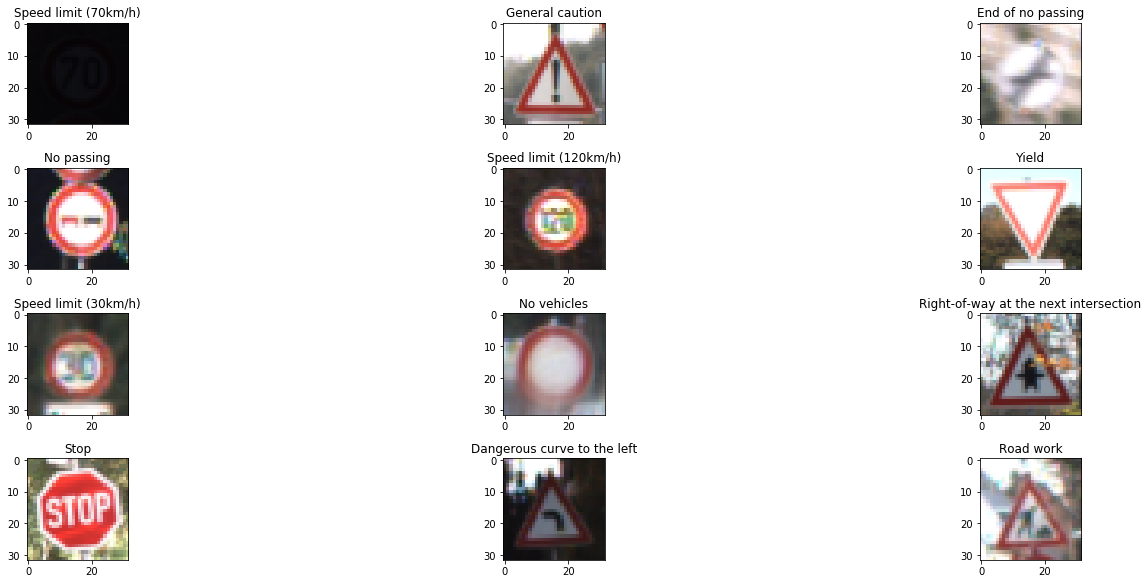

In [4]:
print("Plotting images and labels")
plt.figure(figsize=(20,10))
columns = 3
size = 12
for i in range(size):
    idx = np.random.randint(0, n_train)
    plt.subplot(size / columns + 1, columns, i + 1)
    plt.title(signnames[train['labels'][idx]])
    plt.imshow(train['features'][idx].squeeze())

plt.tight_layout()


## Histogram Showing Data For Training vs Validation vs Test Dataset

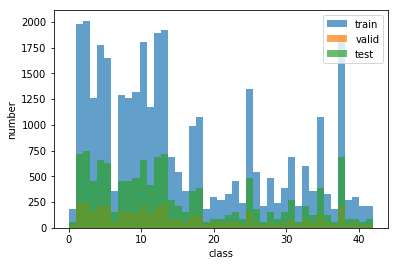

In [5]:
data = [y_train,  y_valid, y_test]
labels = ['train', 'valid', 'test' ]

for i in range(3):
    plt.hist(data[i], bins=n_classes, histtype='stepfilled', alpha=0.7 , label=labels[i])
    
plt.xlabel("class")
plt.ylabel("number")
plt.legend(loc='upper right') 
plt.figure(figsize=(8,8), dpi=72)
plt.show()

## Skewed Data Distribution

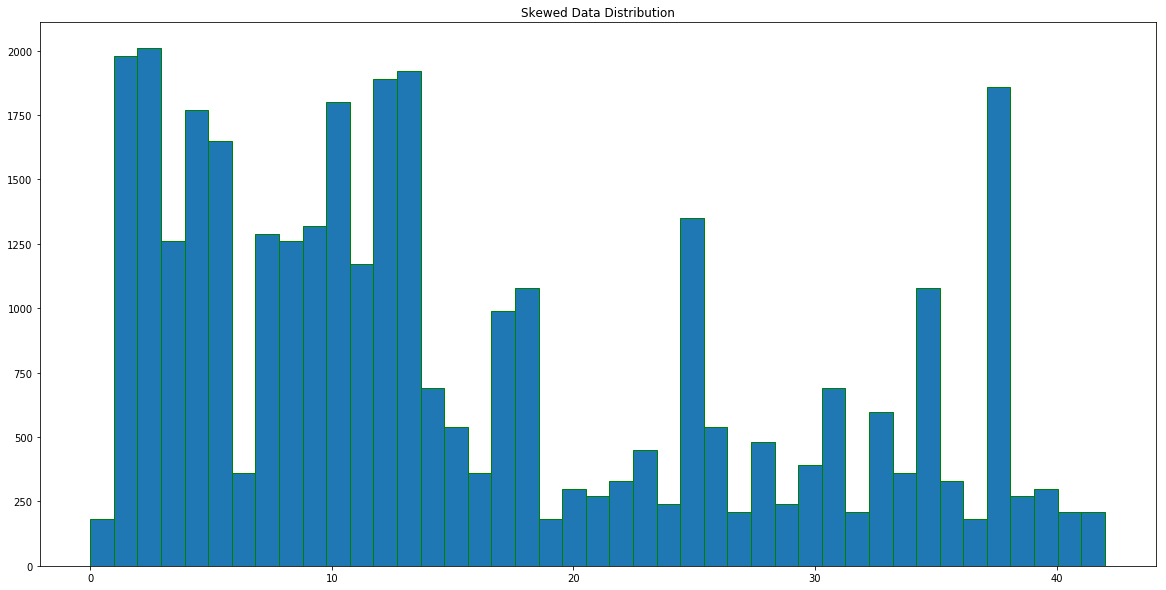

In [6]:
fig = plt.figure(figsize=(20,10))
plt.hist(y_train, bins=n_classes,histtype='bar',edgecolor='g')
plt.title("Skewed Data Distribution")
fig = plt.gcf()
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Preprocessing is applied by converting the image to grayscale and then normalizing the data using linear normalization given by the following equation - 

\\(I_N=(I-\text{Min})\frac{\text{newMax}-\text{newMin}}{\text{Max}-\text{Min}}+\text{newMin}\\)

Where the values of newMax and newMin are between 0 and 1. 

I've included an image showing the original vs grayscale vs normalized data. We can clearly observe that the grayscale and normalized versions are smaller in size. On one hand this reduces noise in the image and as the image of a traffic signal does not convey too much additional information I believe it is alright to lose color information in order to train the network more efficiently. As mentioned in the baseline model converting the images to grayscale improves accuracy.



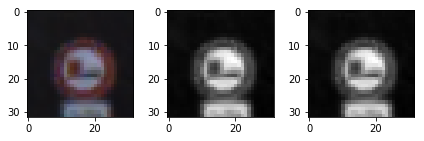

(4410, 32, 32, 1)


In [12]:
# Preprocessing steps
# Convert to grayscale and normalize
def show(x):
    f, axarr = plt.subplots(1,3)
    a = x
    b = np.mean(a, axis=2)
    c = normalize(b)
    axarr[0].imshow(a)
    axarr[1].imshow(b, cmap='gray')
    axarr[2].imshow(c, cmap='gray')
    plt.tight_layout()
    plt.show()
    

def normalize(x):
    return ( x- np.min(x) )/ (np.max(x) - np.min(x))

def preprocess(x):
    return normalize( np.mean(x, axis=3)[:,:,:,np.newaxis] )

#show()
#X_train = preprocess(X_train)
#X_valid = preprocess(X_valid)
index = np.random.randint(0, n_train)
show(X_train[index])
print( preprocess(X_valid).shape ) 

## Augmenting Data

One of the steps I took to improve my predictions was augmenting the network with additional data. This introduces real world issues like rotation, blur and brightness to address the numerous real-world deformations and increases the number of samples of each type to improve predictions.

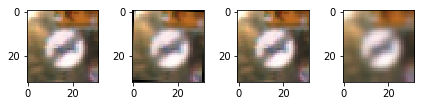

In [13]:
def rotate_image(img):
     rows,cols,depth = img.shape
     M = cv2.getRotationMatrix2D((cols/2,rows/2),5*np.random.choice([-1, 1, 2, -2], 1)[0],1)
     rotated_img = cv2.warpAffine(img,M,(cols,rows))
     return np.asarray(rotated_img, dtype="uint8")

def add_blur(img):
    blur_effect = 5
    blurred_image = cv2.GaussianBlur(img, (blur_effect, blur_effect), 0)
    return blurred_image

def add_brightness(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v += 255
    final_hsv = cv2.merge((h, s, v))
    bright_img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return bright_img

def original(img):
    return img

    
f, axarr = plt.subplots(1,4)
img = train['features'][123]
axarr[0].imshow(original(img))
axarr[1].imshow(rotate_image(img))
axarr[2].imshow(add_brightness(img))
axarr[3].imshow(add_blur(img))
plt.tight_layout()
plt.show()

## Displaying Random Image Data

The following cell displays a random image that I've autogenerated using the effects presented above

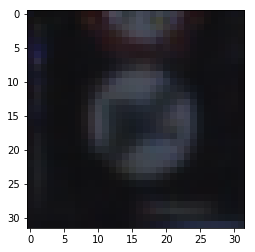

In [14]:
unique_labels, unique_count = np.unique(y_train, return_counts=True)

image_map = {}
for i in range(n_train):
    if y_train[i] not in image_map:
        image_map[y_train[i]] = []
    image_map[y_train[i]].append(i)

# Function to retrieve a random image from the data
def getRandomImage(yidx):
    iidx = image_map[yidx][np.random.randint(len(image_map[yidx]))]
    img = train['features'][iidx]
    choice = np.random.randint(4)
    options = {0 : rotate_image,1 : original,2 : add_blur, 3: add_brightness}
    return options[choice](img)

def getImage(yidx, xidx):
    return train['features'][image_map[yidx][xidx]]

plt.imshow(getRandomImage(42))
plt.show()

## Implementation of Augmentation

The below cells create new data (X_aug and Y_aug). They also display the number of unique samples for each label before and after augmentation.

In [15]:
prev_labels, prev_count = np.unique(y_train, return_counts=True)

total = 0
for c in range(43):
    if unique_count[c] < 2000:
        total+=2000
    else:
        total+=unique_count[c]

X_aug = np.empty([total,32,32,3],dtype=np.uint8)
Y_aug =np.empty([total],dtype=np.uint8)

c = 0
for i in range(43):
    before = c
    for k in range(0, prev_count[i]):
        X_aug[c] = getImage(i, k)
        Y_aug[c] = i
        c+=1
    for j in range(prev_count[i], 2000):
        X_aug[c] = getRandomImage(i)
        Y_aug[c] = i
        c+=1


aug_labels, aug_count = np.unique(Y_aug, return_counts=True)

print(pd.DataFrame(data ={'Original': prev_count, 'Augmented': aug_count}, index=prev_labels))

    Augmented  Original
0        2000       180
1        2000      1980
2        2010      2010
3        2000      1260
4        2000      1770
5        2000      1650
6        2000       360
7        2000      1290
8        2000      1260
9        2000      1320
10       2000      1800
11       2000      1170
12       2000      1890
13       2000      1920
14       2000       690
15       2000       540
16       2000       360
17       2000       990
18       2000      1080
19       2000       180
20       2000       300
21       2000       270
22       2000       330
23       2000       450
24       2000       240
25       2000      1350
26       2000       540
27       2000       210
28       2000       480
29       2000       240
30       2000       390
31       2000       690
32       2000       210
33       2000       599
34       2000       360
35       2000      1080
36       2000       330
37       2000       180
38       2000      1860
39       2000       270
40       2000   

### Showing some of the newly created data

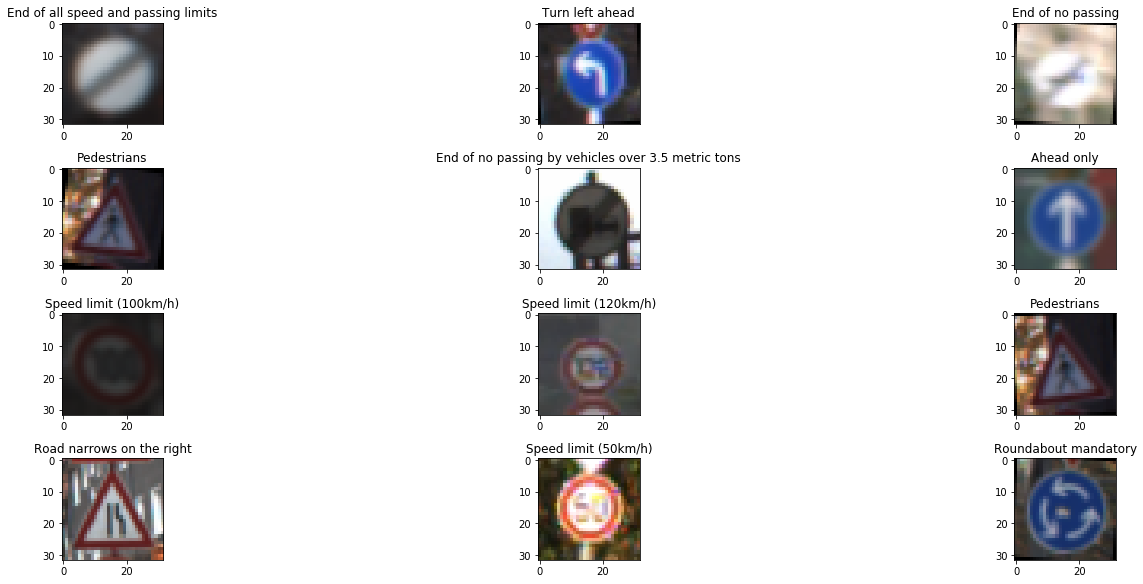

In [16]:
plt.figure(figsize=(20,10))
columns = 3
size = 12

n_aug = X_aug.shape[0]
for i in range(size):
    idx = np.random.randint(0, n_aug)
    plt.subplot(size / columns + 1, columns, i + 1)
    plt.title(signnames[Y_aug[idx]])
    plt.imshow(X_aug[idx].squeeze())

plt.tight_layout()

### Model Architecture

My network used the Lenet Lab as a starting point. I added dropout, convolution and fully-connected layers on top of the current layers


Layer 1
Input: 32 x 32 x 1 image
Conv: (3 x 3 x 32 filter, Stride 1, Ouputs : 30 x 30 x 32 )
Relu Activation

Layer 2
Input: 30 x 30 x 32 
Conv: (3 x 3 x 32 filter, Stride 1, Output: 28 x 28 x 32 )
Relu Activation
Maxpool ( 2 x 2 kernel, 2 x 2 stride )


Layer 3
Input: 14 x 14 x 32 
Conv: (3 x 3 x 64 filter, Stride 1, Output: 12 x 12 x 64 )
Relu Activation
Maxpool ( 2 x 2 kernel, 2 x 2 stride )

Layer 4
Input: 6 x 6 x 64
Conv: (3 x 3 x 64 filter, Stride 1, Output: 4 x 4 x 64 )
Relu Activation

Flatten 4 x 4 x 64 output to 1024 to feed to FC Layers

Layer 4
Input: 6 x 6 x 64
Conv: (3 x 3 x 64 filter, Stride 1, Output: 4 x 4 x 64 )
Relu Activation


Layer 5
Input: 1024 
Output : 512
Relu Activation + Dropout (keep_prob=0.7)

Layer 6
Input: 512
Output : 256
Relu Activation + Dropout (keep_prob=0.7)


Layer 7
Input: 256
Output : 128
Relu Activation


Layer 8
Input: 128
Output : 43
Relu Activation


In [17]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    #print(x.get_shape())
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 30x30x32.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 32), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(32))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Layer 1: Activation.
    conv1 = tf.nn.relu(conv1)

    #print(conv1.get_shape())
    
    # Layer 2: Convolutional. Input= 30 x 30 x 32. Output = 28x28x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 28x28x32. Output = 14x14x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    #print(conv2.get_shape())

    # Layer 3: Convolutional. Input = 14x14x32. Output = 12 x 12 x64
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(64))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    conv3   = tf.nn.relu(conv3)
    

    # Pooling. Input = 12x12x64. Output = 6 x 6 x 64.
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    #print(conv3.get_shape())
    global conv3
    
    # Layer 4: Convolutional. Input = 6x6x64. Output =  4 x 4 x 64
    conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 64), mean = mu, stddev = sigma))
    conv4_b = tf.Variable(tf.zeros(64))
    conv4   = tf.nn.conv2d(conv3, conv4_W, strides=[1, 1, 1, 1], padding='VALID') + conv4_b
    conv4   = tf.nn.relu(conv4)
    
    # print(conv4.get_shape())
    
    # Flatten. Input = 4 x 4 x 64. Output = 1024
    fc0   = flatten(conv4)
    
    #print(fc0.get_shape())
    
    
    #  Layer 5: Fully Connected. Input = 1024. Output = 512.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1024, 512), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(512))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    #print(fc1.get_shape())
        
    #  Layer 6: Fully Connected. Input = 512. Output = 256.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(512, 256), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(256))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    #  Activation.
    fc2    = tf.nn.relu(fc2)

    # Adding Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    #  Layer 7: Fully Connected. Input = 256. Output = 128.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(256, 128), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(128))
    fc3    = tf.matmul(fc2, fc3_W) + fc3_b
    
    #  Activation.
    fc3    = tf.nn.relu(fc3)
    

    # Layer 8 : Fully Connected. Input = 128. Output = 43.
    fc4_W  = tf.Variable(tf.truncated_normal(shape=(128, 43), mean = mu, stddev = sigma))
    fc4_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc3, fc4_W) + fc4_b
    
    #print(logits.get_shape())
    
    return logits

<ipython-input-17-198f2f1c36db>:43: SyntaxWarning: name 'conv3' is assigned to before global declaration
  global conv3


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

## Train the Model
Run the training data through the training pipeline to train the model.
Before each epoch, shuffle the training set.
After each epoch, measure the loss and accuracy of the validation set.
Save the model after training.
You do not need to modify this section.

In [24]:
# Training Step 1

# Preprocess Validation Set
#X_valid = preprocess(X_valid) # do only once 
#X_test = preprocess(X_test) 
#print(X_valid.shape, y_valid.shape)

# Setting initial rate 
rate = 0.001
keep_prob_actual = 0.7
EPOCHS = 10
BATCH_SIZE = 128

In [25]:
print("Creating Features")
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

print("Setting Up Network With Optimizer")
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()    

Creating Features
Setting Up Network With Optimizer


In [26]:
def train(X, Y, rate, keep_prob_actual, BATCH_SIZE, EPOCHS):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = X.shape[0]

        print("Training...")
        for i in range(EPOCHS):
            X, Y = shuffle(X, Y)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X[offset:end], Y[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:keep_prob_actual})

            validation_accuracy = evaluate(X_valid, y_valid,  rate, BATCH_SIZE)
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()

        saver.save(sess, './model')
        print("Model saved")

In [27]:
def evaluate(X, Y, rate, BATCH_SIZE):
    #print(X.shape)
    num_examples = len(X)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X[offset:offset+BATCH_SIZE], Y[offset:offset+BATCH_SIZE]
        #print(batch_x.shape, batch_y.shape)
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Training and testing the model

In [28]:
print("For Augmented Data and the following setup - ", rate, keep_prob_actual, BATCH_SIZE, EPOCHS)
print(preprocess(X_aug).shape)

train(preprocess(X_aug), Y_aug, rate, keep_prob_actual, BATCH_SIZE, EPOCHS)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(preprocess(X_test), y_test, rate, BATCH_SIZE)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

For Augmented Data and the following setup -  0.001 0.7 128 10
(86010, 32, 32, 1)
Training...
EPOCH 1 ...
Validation Accuracy = 0.950

EPOCH 2 ...
Validation Accuracy = 0.966

EPOCH 3 ...
Validation Accuracy = 0.972

EPOCH 4 ...
Validation Accuracy = 0.977

EPOCH 5 ...
Validation Accuracy = 0.976

EPOCH 6 ...
Validation Accuracy = 0.983

EPOCH 7 ...
Validation Accuracy = 0.984

EPOCH 8 ...
Validation Accuracy = 0.984

EPOCH 9 ...
Validation Accuracy = 0.980

EPOCH 10 ...
Validation Accuracy = 0.976

Model saved
Test Accuracy = 0.953


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

Plotting new images
(5, 32, 32, 3) (5,)


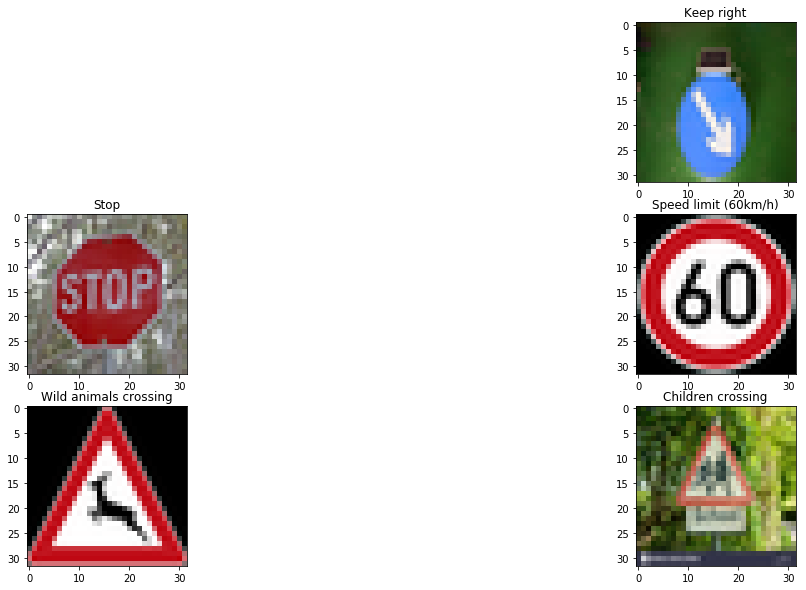

In [37]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

from PIL import Image


def load_image(infilename):
    size = 32, 32
    img = Image.open( infilename ).convert('RGB')
    img = img.resize((32,32), Image.ANTIALIAS)
    return np.array(img.getdata(), np.uint8).reshape(32, 32, 3)

print("Plotting new images")
X_new = np.array([load_image('sample/'+str(i)+'.jpg') for i in range(1, 6)])
y_new = np.array([38, 14, 3, 31, 28])


plt.figure(figsize=(20,10))
columns = 2
size = 5
for i in range(1, 6):
    img=mpimg.imread('sample/'+str(i)+'.jpg')
    plt.subplot(size / columns + 1, columns, i + 1)
    plt.title(signnames[y_new[i-1]])
    plt.imshow(X_new[i-1].squeeze())
    np.append(X_new, img)

    
print(X_new.shape, y_new.shape)

### Predict the Sign Type for Each Image

In [38]:
X_new = preprocess(X_new)

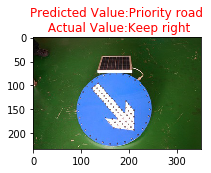

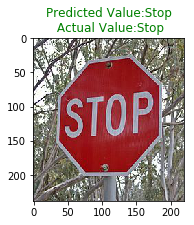

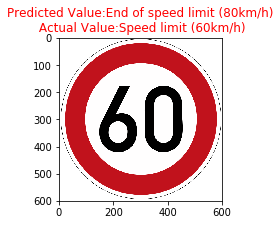

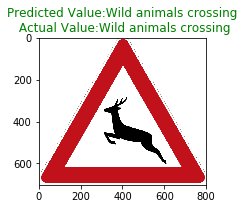

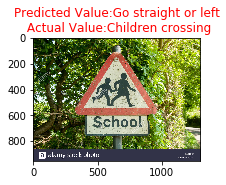

In [39]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predictions = sess.run( tf.nn.softmax(logits), feed_dict={x: X_new, y : y_new, keep_prob: 1 })
    

for i in range(5):
    index = y_new[i]
    predicted_index = predictions[i].argmax()

    img=mpimg.imread('sample/'+str(i+1)+'.jpg')
    
    plt.figure(figsize=(3, 3))
    title = 'Predicted Value:'+signnames[predicted_index]+'\n Actual Value:'+signnames[index]
    plt.title(title, color=['red','green'][predicted_index == index], fontsize=12 )
    plt.imshow(img)

### Analyze Performance

In [41]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    y_new = np.array([y_new[i] for i in range(5)])
    new_accuracy = evaluate(X_new, y_new, rate, BATCH_SIZE)
    print("New Accuracy = {:.3f}".format(new_accuracy))

New Accuracy = 0.400


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

Top 5 softmax probabilities:  [[  3.32562178e-01   2.49569386e-01   1.25876889e-01   5.88091649e-02
    5.29911034e-02]
 [  1.00000000e+00   2.07159001e-09   9.46494480e-11   9.66193358e-12
    7.49235569e-12]
 [  6.91456020e-01   3.07699114e-01   8.08283628e-04   3.23986169e-05
    2.23095321e-06]
 [  5.75864851e-01   4.23274636e-01   7.81806302e-04   3.46549969e-05
    3.14054305e-05]
 [  5.49846530e-01   1.60918236e-01   1.28589749e-01   5.16210943e-02
    3.86738405e-02]]


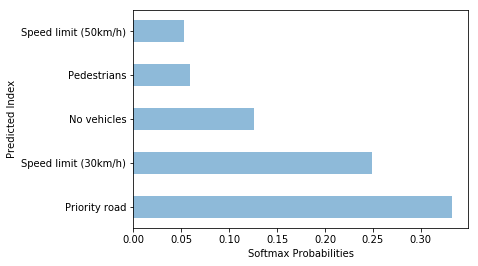

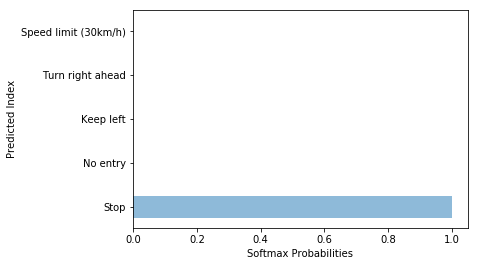

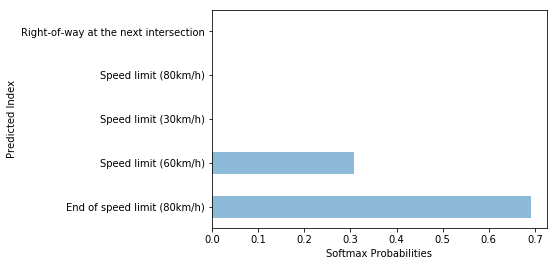

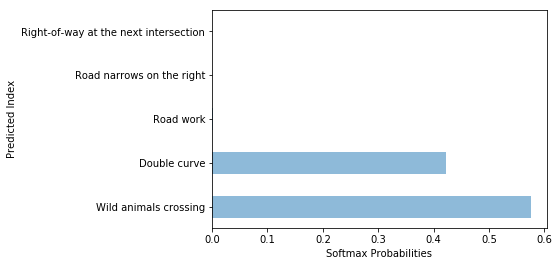

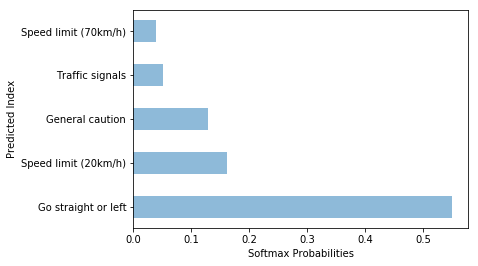

In [43]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    saver.restore(sess,tf.train.latest_checkpoint('.'))
    top_5_probabilities = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5), feed_dict={x: X_new, y: y_new, keep_prob : 1})
    print ('Top 5 softmax probabilities: ', top_5_probabilities.values)

    
n_examples = 5
y_pos = np.arange(n_examples)

for i in range(5):
    plt.barh( y_pos, top_5_probabilities.values[i], align='center', alpha=0.5, height=0.5 )
    plt.yticks(y_pos, signnames[top_5_probabilities[1][i].astype(int)])
    plt.ylabel('Predicted Index')
    plt.xlabel('Softmax Probabilities')
    plt.show()

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


ValueError: num must be 1 <= num <= 49, not 50

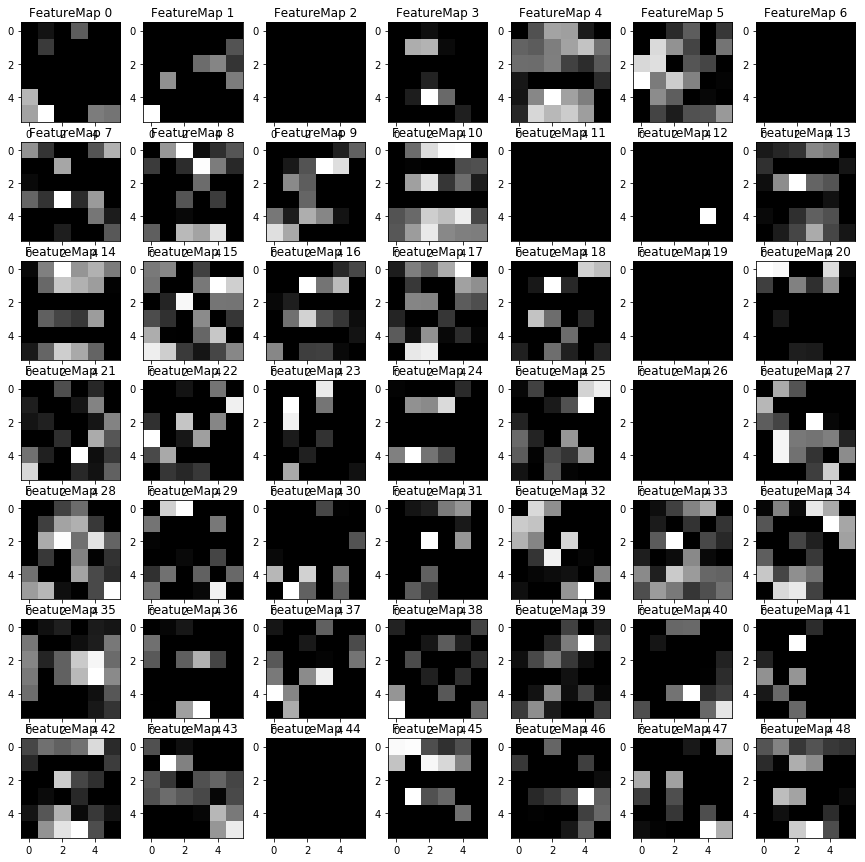

In [162]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input, keep_prob:1.0 })
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(7,7, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
            
with tf.Session() as sess:
    saver.restore(sess,tf.train.latest_checkpoint('.'))
    outputFeatureMap(preprocess(X_aug)[0:1], conv3)